# Supervised Model
Classification with  Random Forest

In [10]:
# Install dependencies as needed:
# !pip install "kagglehub[pandas-datasets]" scikit-learn

import kagglehub
from kagglehub import KaggleDatasetAdapter

# exercicio2_randomforest_heart.py (sem scipy)
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix,  ConfusionMatrixDisplay, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 1. Load Data

In [2]:
file_path = "heart_cleveland_upload.csv"

df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "cherngs/heart-disease-cleveland-uci",  
    file_path,                              
)

print("First 5 records:")
print(df.head())

/var/folders/bp/4bp0nhvd3zd55p3lw4rlzq3w0000gn/T/ipykernel_25323/1091370593.py:3: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


First 5 records:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   69    1   0       160   234    1        2      131      0      0.1      1   
1   69    0   0       140   239    0        0      151      0      1.8      0   
2   66    0   0       150   226    0        0      114      0      2.6      2   
3   65    1   0       138   282    1        2      174      0      1.4      1   
4   64    1   0       110   211    0        2      144      1      1.8      1   

   ca  thal  condition  
0   1     0          0  
1   2     0          0  
2   0     0          0  
3   1     0          1  
4   0     0          0  


In [3]:
print("Columns:", df.columns.tolist())
print(df.head(1))

Columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'condition']
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   69    1   0       160   234    1        2      131      0      0.1      1   

   ca  thal  condition  
0   1     0          0  


| Column     | Variable name (full description)        | Description                                                                 | Variable type        | Indicator for… |
|-----------|------------------------------------------|-----------------------------------------------------------------------------|----------------------|----------------|
| age       | Age                                      | Patient age in years                                                        | Continuous numeric   | Cardiovascular risk associated with aging |
| sex       | Biological sex                            | 0 = female, 1 = male                                                        | Binary               | Sex-related differences in cardiovascular risk |
| cp        | Chest pain type                          | 1: typical angina, 2: atypical angina, 3: non-anginal pain, 4: asymptomatic | Categorical          | Type and severity of clinical manifestation |
| trestbps | Resting blood pressure                   | Resting blood pressure measured at hospital admission (mm Hg)              | Continuous numeric   | Hypertension |
| chol     | Serum cholesterol                        | Total serum cholesterol (mg/dL)                                             | Continuous numeric   | Atherosclerotic risk |
| fbs      | Fasting blood sugar                      | >120 mg/dL = 1, ≤120 mg/dL = 0                                              | Binary               | Hyperglycemia / diabetes |
| restecg  | Resting electrocardiographic results     | 0: normal, 1: ST-T abnormality, 2: left ventricular hypertrophy             | Categorical          | Cardiac electrical abnormalities |
| thalach  | Maximum heart rate achieved              | Maximum heart rate achieved during exercise test (bpm)                      | Continuous numeric   | Functional capacity and exercise response |
| exang    | Exercise-induced angina                  | 1 = yes, 0 = no                                                             | Binary               | Exercise-induced ischemia |
| oldpeak  | ST segment depression                   | ST depression induced by exercise relative to rest                          | Continuous numeric   | Severity of myocardial ischemia |
| slope    | Slope of the ST segment                  | 1: upsloping, 2: flat, 3: downsloping                                       | Categorical          | Prognostic response to exercise |
| ca       | Number of major vessels                  | Number of major coronary vessels visualized by fluoroscopy (0–3)            | Ordinal              | Extent of coronary artery disease |
| thal     | Thallium stress test result              | 3: normal, 6: fixed defect, 7: reversible defect                            | Categorical          | Myocardial perfusion |
| condition| Presence of heart disease (target)       | 0 = absence of heart disease, 1 = presence                                  | Binary (Target)      | Heart disease diagnosis |


# 2. Define categorical and numerical variables based on the description.

In [4]:
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']

# 3. Remove outliers based on IQR

In [5]:
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    filter = (df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR)
    df = df[filter]

# 4. Split in X and Y

In [6]:
X = df[categorical_cols + numerical_cols]
y = df["condition"]

# 5. Split in train/test

In [7]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, stratify=y, random_state=0 )

| Category | Models | Scaling Required |
|--------|--------|------------------|
| Distance-based | KNN, K-Means, DBSCAN, Hierarchical Clustering | ✅ Yes |
| Gradient-based | Logistic Regression, Linear Regression, SVM, Ridge, Lasso | ✅ Yes |
| Neural Networks | MLP, Deep Learning models | ✅ Yes |
| Tree-based | Decision Tree, Random Forest, Gradient Boosting, XGBoost | ❌ No |


In [8]:
# Scaling:
preprocessor = ColumnTransformer(
    transformers=[
    ("num", StandardScaler(), numerical_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)

pipeline = Pipeline([
    ("pre", preprocessor),
    ("clf", RandomForestClassifier(random_state=0))
])

#  7. Cross-validation

# Avoid Overfitting (Model learns too much from training data → fails on new data)
Overfitting occurs when: the model performs very well on training data but performs poorly in validation/testing

In other words: the difference between training and validation is large.

### Strategies to avoid it:
• Separate training/testing
• Cross-validation
• Regularization

# When to suspect overfitting?
- e.g.: very different scores -> Scores: [0.92, 0.52, 0.90, 0.55, 0.91]: High variance ⇒ the model does not generalize well ⇒ possible overfitting.

or
- Training accuracy is much higher than validation accuracy: (Training accuracy: 0.99
- Average validation accuracy: 0.82) -> Very large difference ⇒ clear overfitting.

* What is a “good” accuracy? It depends on the problem:

- Common binary classification → 70%–85% is already reasonable
- Balanced and simple data → can reach 90%
- Medical problems → may require > 90%
- Complex problems → 60%–70% is already good
- There is no absolute value.

# cross_val_score() from sklearn.model_selection lib

context

Performs 5-fold cross-validation

In each fold:
- 80% of the data → training
- 20% → validation

The pipeline is reset from scratch at each iteration: (preprocessing + model)

This measures generalization capability, not inflated performance.

In [16]:
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print(cv_scores)
print(cv_scores.mean())

# context: Accuracy = (TP + TN) / (TP + TN + FP + FN)
# In other words: the percentage of correct predictions in unseen data (on average, across the 5 tests).
print(f"Average accuracy (before optimization - v_scores.mean()): {cv_scores.mean():.3f}")

[0.78571429 0.73809524 0.88095238 0.78571429 0.87804878]
0.8137049941927991
Average accuracy (before optimization - v_scores.mean()): 0.814


[update] 
The cross-validation results show an average accuracy of 0.814, indicating that the model correctly classifies approximately 81% of the cases on unseen data before hyperparameter optimization. 

The accuracy values across the five folds range from 0.738 to 0.881, suggesting moderate variability but overall stable performance, with no strong indication of overfitting. 

This result provides a solid baseline for comparison with the optimized model obtained via GridSearchCV.

# result Analysis 
CV Score:
[0.78571429 0.73809524 0.88095238 0.78571429 0.87804878]
cv_scores -> Each value represents:
Model accuracy at a different fold

In other words:
- 5 “mini-experiments”
- Each with distinct validation data

CV Scores Mean: 0.8137049941927991

this means that, on average, the model correctly predicts 85% of cases in unseen data, before optimization.

This means:
- more reliable than a single train/test split
- less subject to the luck of the split

# 8. Optimizing with GridSearchCV

In [12]:
param_grid = {
"clf__n_estimators": [50, 100],
"clf__max_depth": [None, 10, 20]
}

grid = GridSearchCV(pipeline, param_grid, cv=5)
grid.fit(X_train, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...om_state=0))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'clf__max_depth': [None, 10, ...], 'clf__n_estimators': [50, 100]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also displ

# Result 
Hyperparameter optimization was performed using GridSearchCV, evaluating combinations of the number of trees and maximum tree depth through 5-fold cross-validation, in order to identify the model configuration with the best generalization performance.

### Optimization was:
- max_depth: 10
- best_estimator___clf__n_estimators = 50

# 9. Model Evaluation

In [13]:
y_pred = grid.predict(X_test)

In [14]:
y_train_pred = grid.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

print(f"Train accuracy: {train_accuracy:.3f}")


Train accuracy: 1.000


Confusion Matrix: 
 [[29  2]
 [ 6 16]]

 Classification Report: 
               precision    recall  f1-score   support

           0       0.83      0.94      0.88        31
           1       0.89      0.73      0.80        22

    accuracy                           0.85        53
   macro avg       0.86      0.83      0.84        53
weighted avg       0.85      0.85      0.85        53



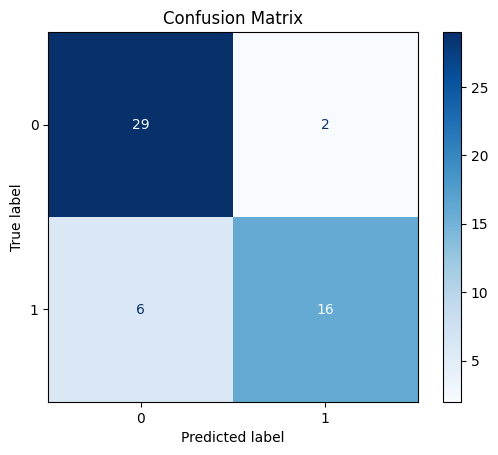

In [15]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: \n", cm)
print("\n Classification Report: \n" , classification_report(y_test, y_pred))

import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")    
plt.title("Confusion Matrix")
plt.show()

# 10. Forecast for new patient (fictitious average values)

In [16]:
novo_paciente = pd.DataFrame([{
    'age': 55, 'trestbps': 130, 'chol': 245, 'thalach': 150,
    'oldpeak': 1.0, 'ca': 0, 'sex': 1, 'cp': 1, 'fbs': 0,
    'restecg': 1, 'exang': 0, 'slope': 2,
    'thal': 2
}])


pred_novo = grid.predict(novo_paciente)
print(f"\n Predicted risk for new patient: {'Patient Sick' if pred_novo[0] == 1 else 'Healthy'}")


 Predicted risk for new patient: Healthy
